# MCMC with Astropy models and emcee

This is a step-by-step tutorial aimed at teaching users how to take some of the models 
defined in `astropy.modeling` and doing both some simple fitting as well as 
Markov Chain Monte Carlo sampling using `emcee`. 

## Some background

You have collected some data. You have some kind of physical (?) model that might 
describe what is going on in your data. There are several things you can do in order 
to try and make inferences about your model based on the data that you have collected.
This is why we have statistics. This is *not* a statistics tutorial.
If you're new to this, please read about (Bayesian) statistics first. 

[Add some references]

Instead, here, I'm going to give you an idea how to take the models in `astropy` and 
use them to build statistical models, fit them with `scipy.optimize` and sample them 
using `emcee`.

### But `astropy.modeling` has a fitting package

This is true. Be aware, however, that the fitting routines in `astropy.modeling` only work 
for some very specific assumptions about your data and your model.
Specifically, it assumes that your measurement uncertainties ("errors") are distributed 
following a Gaussian distribution. Is this true? Then you're fine.

If your uncertainties do not follow a Gaussian distribution, you might want to do something 
more complicated, because the assumption of Gaussian uncertainties is currently hardcoded 
into the `Fitter` classes in `astropy.modeling`. Additionally, there is currently no way 
to define more complex models including priors and posteriors, or do Markov Chain Monte 
Carlo sampling. 

But fear not! It's not that hard. Okay, ready? Go!

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import seaborn as sns
except ImportError:
    print("Install seaborn. It help you make prettier figures!")

import numpy as np
from astropy.modeling import models

This should work with the models defined in `astropy.modeling.models`. 
If you don't know what those are, head over to the [astropy documentation](http://docs.astropy.org/en/stable/modeling/) and check out the docs.

Here's how you instantiate a simple 1-D Gaussian:

In [88]:
g = models.Gaussian1D()

To use this, let's make some data:

<Container object of 3 artists>

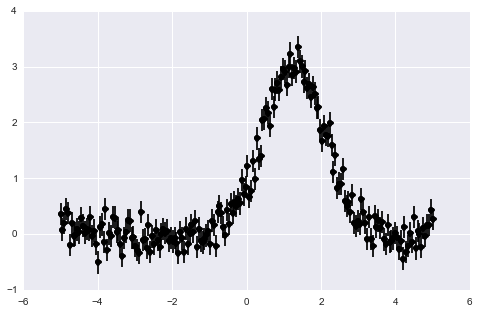

In [89]:
# Generate fake data
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)
yerr = 0.2

plt.figure(figsize=(8,5))
plt.errorbar(x, y, yerr=yerr, fmt='ko')


That looks kind of like a Gaussian.

Now comes the harder part: we need to define the function we want to optimize or sample.

In statistics, this is either a **likelihood**, which describes the probability of the 
data given the model and the parameters, or a **posterior**, which is defined as the likelihood
times the **prior**, which is everything you know about the model *before* you looked at the 
data.

Before we do this, it is useful to write a *general* way to define functions you can 
optimize or sample. They don't have to be a likelihood or a posterior. 

So let's do that first:

In [ ]:
from abc import ABCMeta
import abc

class ObjectiveFunction(object):
    __metaclass__ = ABCMeta

    @abc.abstractmethod
    def __call__(self):
        """
        Any objective function must have a `__call__` method that 
        takes parameters as a numpy-array and returns a value to be 
        optimized or sampled.
        
        """
        pass



This is a super simple class. All I've done is required that any sub-class *has* to have a 
`__call__` method. 
If all you want is a simple example, you can just ignore it.


### Maximum Likelihood Analysis

We're going to start with likelihoods and use optimization to maximize that likelihood. 
This broadly falls under a branch of statistics called Maximum Likelihood Analysis.

For this, we're going to define a general `LogLikelihood` class, which we can then 
use as a container to define specific classes for different data uncertainties.
Note that we're going to compute the *log*-likelihood instead of the likelihood 
because it's easier to compute.

Here's the container class.



In [99]:
class LogLikelihood(ObjectiveFunction):
    __metaclass__ = ABCMeta

    def __init__(self, x, y, model):
        """
        x : iterable
            x-coordinate of the data. Could be multi-dimensional.
        
        y : iterable
            y-coordinate of the data. Could be multi-dimensional.
        
        model: probably astropy.modeling.FittableModel instance
            Your model
        """
        self.x = x
        self.y = y
        
        self.model = model
        
    @abc.abstractmethod
    def evaluate(self, parameters):
        """
        This is where you define your log-likelihood. Do this!
        
        """
        pass
    
    @abc.abstractmethod
    def __call__(self, parameters):
        return self.loglikelihood(parameters)

Again, if you just want something simple, you can ignore it. 

The idea here is that all likelihoods must have a method `evaluate` that actually 
computes the likelihood, and a `__call__` method, which will make it easy to put 
this into a `scipy.optimize` routine.

Note that in the case above, the likelihood takes data `x` and `y`, which in general 
don't have to be one-dimensional vectors (though for the purpose of this tutorial, 
they will be). It also takes an instance of an `astropy.modelling.Model`, which describes 
the function you use to model the data.

Now let's define a specific likelihood. By far the most-used likelihood in astronomy 
is a *Gaussian* likelihood. This is also sometimes called *chi-square* likelihood (though 
note that you could also define a likelihood where the data uncertainties are distributed 
following a chi-square distribution!) and assumed that the uncertainties on the data 
points follow a Gaussian distribution.

In [109]:
from astropy.modeling.fitting import _fitter_to_model_params
from astropy.modeling import models

class GaussianLogLikelihood(LogLikelihood, object):
    
    def __init__(self, x, y, yerr, model):
        """
        A Gaussian likelihood.
        
        Parameters
        ----------
        x : iterable
            x-coordinate of the data
            
        y : iterable
            y-coordinte of the data
        
        yerr: iterable
            the error on the data
            
        model: an Astropy Model instance
            The model to use in the likelihood.
        
        """
        
        self.x = x
        self.y = y
        self.yerr = yerr
        self.model = model
        
        
    def evaluate(self, pars):
        _fitter_to_model_params(self.model, pars)
        
        mean_model = self.model(self.x)
        
        loglike = np.sum(-0.5*np.log(2.*np.pi) - np.log(self.yerr) - (self.y-mean_model)**2/(2.*self.yerr**2))
        
        return loglike
    
    def __call__(self, pars):
        return self.evaluate(pars)
        
        

Notice that the model now takes the data `x` and `y`, but also a variable `yerr` describing 
the uncertainties on `y`. 

The methods `evaluate` and `__call__` take a vector `pars`, which is just a list of the model 
parameters. We store this as a list (or `numpy.array`) because both `scipy.optimize` as well as 
`emcee` expect the parameters to be in this form. In order to interface with the model parameters, 
which are stored as attribute on the `self.model` instance in the class, we need to do a little
bit of book-keeping. Thankfully, `astropy.modeling` makes that job easy: you can import and 
use the `_fitter_to_model_params` function from `astropy.modeling.fitting` to map the list of 
parameters onto the parameters in the model.

Now for a practical example. We earlier made some fake data (this example is taken straight from 
the `astropy.modeling` documentation). Now we are going to fit it with a Gaussian model.

Let's define this Gaussian first, and also give it some starting parameters we're guessing:

In [110]:
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)

Next, let's instantiate an object of the `GaussianLikelihood` class we made above using the data `x`, `y` and `yerr`, and the Gaussian model we've defined above:

In [111]:
loglike = GaussianLogLikelihood(x, y, yerr, g_init)

What's the likelihood for some parameters we guess? The list of parameters encodes (`amplitude`, `mean`, `stddev`).

In [112]:
loglike([1, 0, 5])

-2236.2247911223435

Feel free to play around with the parameters to see how the likelihood changes.

But fundamentally, playing around with the likelihood until you think you got the right parameters 
is a really inefficient way to go about this. 

Instead, we're going to use numerical optimization to find the "best" parameters. 
Note that optimization in general is pretty difficult, and very dependent on the problem and 
the initial parameters you give the optimization routine. 
You might need to run the optimization routine several times iteratively until you get a good 
result.

Also note that in general, optimization will be much more reliable and much faster if you can 
compute gradients, but this is beyond the scope of this simple tutorial.

In [113]:
import scipy.optimize

The first thing we actually need to do is define a *negative* log-likelihood.
This is because in practice, optimization routines work by *minimizing* the function. 
Minimizing the negative log-likelihood is formally the same as maximizing the log-likelihood, 
so this is why we use the negative log-likelihood below:

In [114]:
neg_loglike = lambda x: -loglike(x)

Now we're ready to fit!

First, we'll set some starting parameters, then do the actual optimization:

In [115]:
start_params = [1, 0, 1]
opt = scipy.optimize.minimize(neg_loglike, start_params, method="L-BFGS-B", tol=1.e-10)

`opt` contains the information from the optimization:

In [116]:
opt

   status: 0
  success: True
     nfev: 68
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      fun: -37.228046736148386
        x: array([ 3.04705241,  1.27430145,  0.81353503])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
      jac: array([ -3.62376795e-05,  -4.26325641e-05,  -1.02318154e-04])
      nit: 13

As you can see, the optimization finished successfully (`success` is `True`). 


In [117]:
print("The value of the negative log-likelihood: " + str(opt.fun))

The value of the negative log-likelihood: -37.2280467361


The parameters at the minimum are stored in the attribute `opt.x`:

In [118]:
opt.x

array([ 3.04705241,  1.27430145,  0.81353503])

In order to plot them together with the data, we need to get them back into the model 
with the function we used before in the `GaussianLogLikelihood` class:

In [119]:
fit_pars = opt.x
_fitter_to_model_params(loglike.model, fit_pars)

Now we can plot:

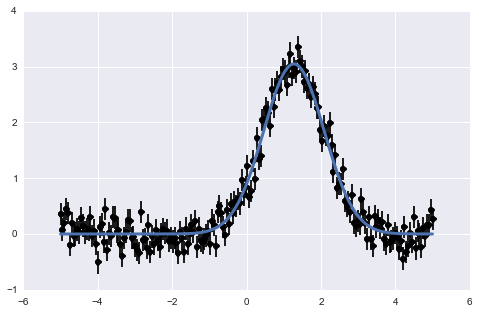

In [120]:
plt.figure(figsize=(8,5))
plt.errorbar(x, y, yerr=yerr, fmt='ko')

plt.plot(x, loglike.model(x), lw=3)

As you can see, our model does a pretty good job!

## Defining Posteriors and Using MCMC

Markov Chain Monte Carlo cannot be used on likelihoods. 
This is because MCMC is designed to sample the distribution 
of the parameters given the data, which is also called 
the *posterior*, i.e. the *prior* times the *likelihood*.

So instead of defining a `LogLikelihood`, we're going to define 
a `LogPosterior` in a very similar way. 

Again, below is the more general class; ignore this if you only care 
about the specific implementation.

In [122]:
class LogPosterior(ObjectiveFunction):
    __metaclass__ = ABCMeta
    
    def __init__(self, x, y, model):
        """
        x : iterable
            x-coordinate of the data. Could be multi-dimensional.
        
        y : iterable
            y-coordinate of the data. Could be multi-dimensional.
        
        model: probably astropy.modeling.FittableModel instance
            Your model
        """

        self.x = x
        self.y = y
        self.model = model

    @abc.abstractmethod
    def loglikelihood(self, parameters):
        pass
    
    @abc.abstractmethod        
    def logprior(self, parameters):
        pass
    
    def logposterior(self, parameters):
        return self.logprior(parameters) + self.loglikelihood(parameters)
    
    def __call__(self, parameters):
        return self.logposterior(parameters)

Any subclass of `LogPosterior` *must* implement a `logprior` and a `loglikelihood` method. 
This is because it is impossible to define a posterior without either likelihood or prior.

Any subclass can also call the `logposterior` and the `__call__` method from the superclass.
The `logposterior` method shouldn't change for any subclass, since the posterior is 
generally defined this way by probability theory, and the `__call__` method is just convenience.

We can now also define a posterior for the Gaussian uncertainties we used earlier.
This will include the same likelihood function that was used for the `GaussianLogLikelhood` class, 
but I've also hard-coded in some priors.

Note that priors are hard! Think very carefully about the priors you apply to your parameters. 
In general, they should obey two rules: (1) they need to be proper, that is, the integral of the prior 
must be normalized to one, and (2) they should reflect your knowledge about the parameters prior
to collecting the data. 

Here's the class for the Gaussian log-posterior. Because I'm lazy, I've applied bounded flat priors with 
some sane boundaries for all parameters. Note that for the width and the amplitude, I used a 
flat prior on the log of the parameters:

In [123]:
logmin = -10000000000000000.0

class GaussianLogPosterior(LogPosterior, object):
    
    def __init__(self, x, y, yerr, model):
        
        self.x = x
        self.y = y
        self.yerr = yerr
        self.model = model
        
    def logprior(self, pars):
        """
        Some hard-coded priors.
        
        """
        # amplitude prior
        amplitude = pars[0]
        logamplitude = np.log(amplitude)
        
        logamplitude_min = -8.
        logamplitude_max = 8.0 
        p_amp = ((logamplitude_min <= logamplitude <= logamplitude_max) / \
                      (logamplitude_max-logamplitude_min))
        
        # mean prior
        mean = pars[1]
        
        mean_min = self.x[0]
        mean_max = self.x[-1]
        
        p_mean = ((mean_min <= mean <= mean_max) / (mean_max-mean_min))

        # width prior
        width = pars[2]
        logwidth = np.log(width)
        
        logwidth_min = -8.0
        logwidth_max = 8.0
        
        p_width = ((logwidth_min <= logwidth <= logwidth_max) / (logwidth_max-logwidth_min))

        pp = p_amp*p_mean*p_width
        
  
        if pp == 0 or np.isfinite(pp) is False:
            return logmin
        else:
            return np.log(pp)
        
    
    def loglikelihood(self, pars):
        _fitter_to_model_params(self.model, pars)
        
        mean_model = self.model(self.x)
        
        loglike = np.sum(-0.5*np.log(2.*np.pi) - np.log(self.yerr) - (self.y-mean_model)**2/(2.*self.yerr**2))

        return loglike
    

Okay, let's try it out!

In [124]:
lpost = GaussianLogPosterior(x, y, yerr, g_init)
lpost([1, 0, 1])

-2274.4807029437757

Again, you can play with the parameters and see how they change. Notice that if you set either 
the first or the last parameter to a negative number, the log-posterior becomes *very* small.
This is because negative values aren't allowed by the prior, so that in theory, the prior should 
be zero. In practice, to avoid numerical problems, we encode this by giving the log-posterior 
a very, very small number.

Now we can do the same thing as before, i.e. fit the posterior distribution. This is generally 
called a *maximum-a-posteriori* estimate. As for the log-likelihood, we need to minimize the 
*negative* log-posterior instead of the posterior itself:

In [125]:
neg_lpost = lambda x: -lpost(x)

start_params = [1, 0, 1]
opt = scipy.optimize.minimize(neg_lpost, start_params, method="L-BFGS-B", tol=1.e-10)

fit_pars = opt.x
_fitter_to_model_params(loglike.model, fit_pars)

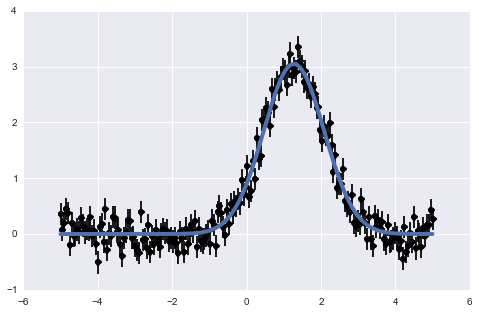

In [126]:
plt.figure(figsize=(8,5))
plt.errorbar(x, y, yerr=yerr, fmt='ko')

plt.plot(x, lpost.model(x), lw=4)

Looks pretty good. 

What about MCMC? For this, we're importing Dan Foreman-Mackey's MCMC sampler [emcee](http://dan.iel.fm/emcee/current/).

We're also going to use the numerical differentiation tool in `statsmodels` to 
compute the approximate second derivative of the posterior with respect to the 
best-fit parameters. This will just serve as a starting point for the MCMC.

In [127]:
from statsmodels.tools.numdiff import approx_hess
phess = approx_hess(opt.x, neg_lpost)

cov = np.linalg.inv(phess)

Now we're ready for the MCMC run:

In [128]:
import emcee

# define some MCMC parameters
nwalkers = 500
ndim = opt.x.shape[0]
threads = 4
burnin = 200
niter = 200

# starting parameters for the walkers
p0 = np.array([np.random.multivariate_normal(opt.x, cov) for
               i in range(nwalkers)])

# initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost, threads=threads)

# run the burn-in
pos, prob, state = sampler.run_mcmc(p0, burnin)

# reset the sampler
sampler.reset()

# do the actual MCMC run
_, _, _ = sampler.run_mcmc(pos, niter, rstate0=state)


What is the acceptance probability?

In [129]:
print("Acceptance fraction: " + str(np.nanmean(sampler.acceptance_fraction)))

Acceptance fraction: 0.64271


Let's plot the MCMC samples as a function of sample number. 
This can give you an idea whether the MCMC chains converged (no trends in the 
plots) or whether it has not yet converged to the posterior distribution:

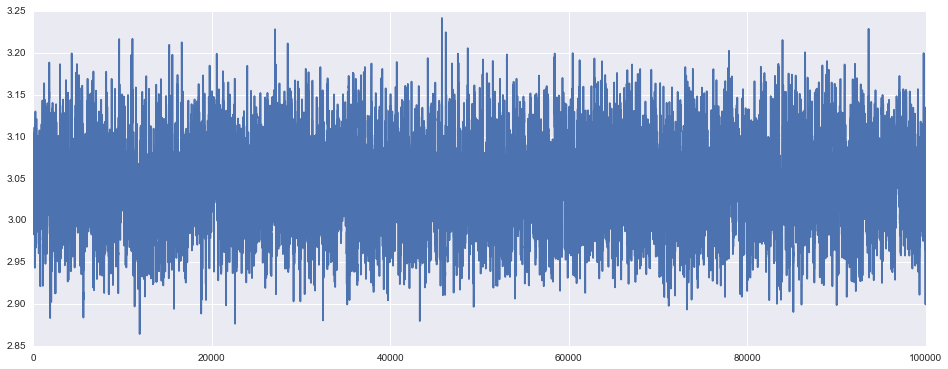

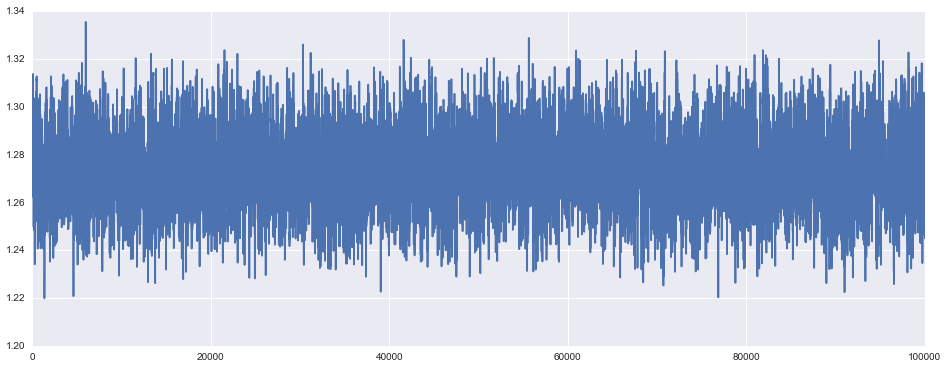

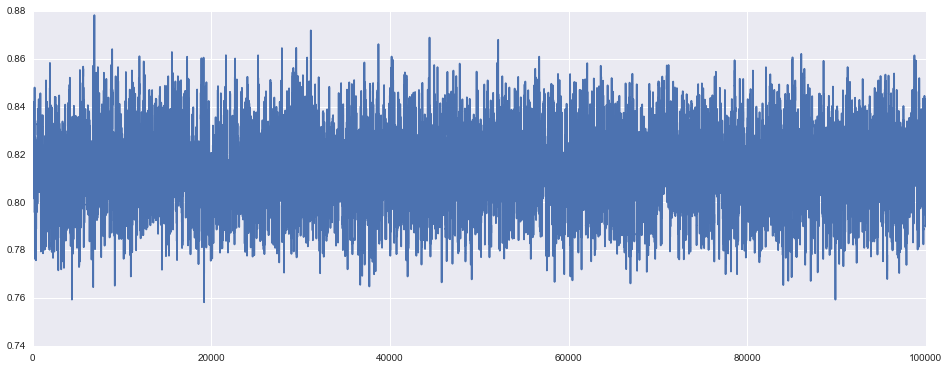

In [130]:
mcall = sampler.flatchain.T
for chain in mcall:
    plt.figure(figsize=(16,6))
    plt.plot(chain)
    

In order to look at the parameters, we'll use the `corner` package.
On the diagonal are marginal distributions of the three parameters (amplitude, mean, standard deviation), 
on the off-diagonal are the correlations between each of the two parameters. 

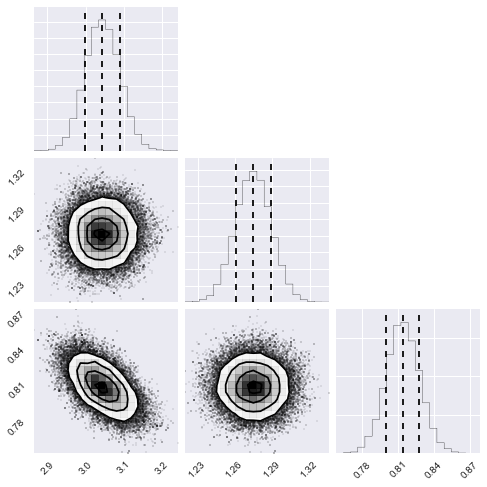

In [131]:
import corner
corner.corner(sampler.flatchain,
              quantiles=[0.16, 0.5, 0.84],
              show_titles=False, title_args={"fontsize": 12});


And that's it! You could do the same for, say, a Poisson likelihood, or two-dimensional data, and it should work more or less in exactly the same way!